### Introduction
This notebook serves as an entry point for working with the HTCV Fully Supervised MGS project. It provides a step-by-step guide to training a deep learning model using a configurable Grid Search over key training hyperparameters. It's practical introduction to the repository itself — explaining how its configuration system, training logic, and data handling can be used to run own experiments or reproduce ours.

It covers the core workflow:
- Defining a hyperparameter search space
- Setting up the training configuration
- Loading the dataset with transformations
- Choosing a data split strategy

The focus here is on Grid Search. A separate notebook for Optuna-based hyperparameter optimization is also available.


### Prerequisites
Before running this notebook, make sure you have:
- Installed all required packages from requirements.txt
- Prepared your dataset in the expected format (see README for structure or section 3 below for details)
- Run this notebook from the root of the repository (e.g., project_root/)

In [ ]:
from pathlib import Path

import torch

from datamodule.transforms import get_train_transforms, get_val_transforms
from utils.model import get_model
from utils.explain import EvaluationPipeline
from utils.optimizer import get_optimizer
from configs.config import TrainingConfig, GridSearchSpaceConfig, DatasetConfig
from search.experiment import Experiment
from search.search_strategy import GridSearch
from datamodule.splitter import KFoldSplit, RandomSplit
from configs.constants import CLASS_WEIGHTS, DATASET_MEAN, DATASET_STD

## 1. Create a search space configuration
To give a nice interface to the gridsearch algoThis repository currently supports tuning of several training-related hyperparameters as part of the model optimization process. The table below outlines the supported parameters, their type (continuous or discrete), and any specific options or sub-parameters available:

| Hyperparameter              | Type       | Supported Options / Notes                                     |
| --------------------------- | ---------- | ------------------------------------------------------------- |
| **Learning rate**           | Continuous | Any float value (e.g. `1e-3`, `5e-4`)                         |
| **Learning rate scheduler** | Discrete   | `StepLR (step_size, gamma)`, `CosineAnnealingLR (T_max)`      |
| **Optimizer**               | Discrete   | `Adam`, `SGD (momentum)`                                      |
| **Weight decay**            | Continuous | Regularization factor; any float value                        |
| **Batch size**              | Discrete   | Must be chosen from a defined list (e.g. `[32, 64, 128]`)     |
| **Number of epochs**        | Discrete   | Number of full passes through the dataset (e.g. `[100, 200]`) |

Parameter combinations which aren't change the results of the model training, such as variation of momentum when using Adam optimizer are filtered out automatically. But to be sure check the printed search combination in the terminal output when starting the experiment in section 5 below.

Moreover the parameters `model_name`, `pretrained`, and `num_classes` are also supported, which allow you to specify the model architecture, whether to use pretrained weights, and the number of output classes respectively. To run a model beside ResNet18, the model builder function `get_model` from the training configuration must be adapted accordingly.


In [ ]:
search_space = GridSearchSpaceConfig(
        batch_size=[32],
        optim=["Adam", "SGD"],    # Optimizers to test, e.g., ["Adam", "SGD"]
        weight_decay=[0.001],
        learning_rate=[0.001],
        epochs=[10],              # 10 epochs since this is a demo, adjust as needed 
        lr_scheduler=["step"],
        scheduler_step_size=[5],
        scheduler_gamma=[0.5],
        scheduler_t_max=[0],
        momentum=[0.0],
        
        model_name= ["resnet18"], # Name of the model architecture, e.g., ["resnet18"]
        pretrained= [False],      # Whether to use pretrained weights, e.g., [False] for training from scratch
        num_classes= [2],         # Number of output classes, e.g., [2] for binary classification
).to_grid_dict()

## 2. Create a training configuration
The training configuration is a dictionary that contains necessary parameters for the training of the model. 

### Important Note
Save the class weights of your dataset in the `configs/constants.py` file. The class weights are used to balance the loss function during training, especially for imbalanced datasets. The weights should be a list of floats, where each float corresponds to the weight of a class in the dataset.

In [4]:
# Compute normalized inverse class weights for balancing
class_weights = {k: 1 / v for k, v in CLASS_WEIGHTS.items()}  # Invert frequencies
class_weights = {k: v / sum(class_weights.values()) for k, v in class_weights.items()}  # Normalize to sum=1

# Define random seeds for each fold (only necessary if KFold split is used)
# The length of this list should match the number of folds in your KFold split
fold_seeds = [42, 43, 44]

# Create the training configuration
trainer_config = TrainingConfig(
    model_builder=get_model,                     # Function to build the model (shouldn't by replaced but can be modified)
    optimizer_builder=get_optimizer,             # Function to build the optimizer (shouldn't by replaced but can be modified)
    fold_seeds=fold_seeds,                       # One seed per CV fold
    shuffle=True,                                # Shuffle training data each epoch
    early_stopping=True,                         # Enable early stopping
    patience=20,                                 # Stop if no improvement for 30 epochs
    main_metric="loss",                          # Main metric to monitor for early stopping (possible are ["loss", "acc", "f1", "precision", "recall"])
    balancing_strategy="weighted_loss",          # Use weighted loss for class imbalance (possible are ["no_balancing", "weighted_loss", "oversampling"])
    class_weights=class_weights,                 # Must be provided if using weighted_loss balancing strategy
    device="cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available
).to_dict()

print("cuda" if torch.cuda.is_available() else "cpu")

cpu


## 3. Create Dataset configuration
In this step, we configure the dataset to be used during training and validation. Instead of passing a pytorch Dataset object directly, the training pipeline uses a configuration dictionary to allow compatibility with the search strategy implementations like GridSearch and Optuna. The dataset config must include the following keys:
- `data_dir`: Path to the dataset root directory.
- `dataset_type`: A string identifier specifying the internal dataset type (e.g., "default", "cached", "nobg").
- `transforms`: A dictionary of transformations with keys "train" and "val".

### Supported Dataset Types
The dataset types differ primarily in how the data is structured on disk and how they are preprocessed internally. The currently supported dataset types are:
dataset_type|Description|Directory Structure
---|---|---
default|Loads images from disk lazily (one at a time)|data/*.jpg, labels/labels.csv
cached|Loads all images into memory at once to speed up training. Same structure as default.| data/*.jpg, labels/labels.csv
nobg|Loads two versions of each image (with and without background). |data_nobg/\*.jpg, data/\*.jpg, labels/labels.csv

Each type expects that the given `data_dir` contains the necessary subdirectories and files as described in the table above. 

### Internal Dataset Handling
Internally, dataset creation is handled by the get_dataset_and_subsets(config) function in dataset.py. This function loads the appropriate dataset based on dataset_type and returns the full dataset object and a factory function (subset_factory) that generates training/validation subsets with the correct transforms applied.


### Adding a New Dataset Type
If you want to add support for a new dataset type, you must create a new dataset class that inherits from torch.utils.data.Dataset and implements __len__ and __getitem__. Update the get_dataset_and_subsets() function in dataset.py to include a new elif dataset_type == "your_type" block that instantiates your custom dataset. Optionally wraps it with a new or existing TransformedSubset class to apply augmentations. Define a TransformedSubset variant if your dataset requires special handling during training/validation (e.g., conditional logic for which version of the image to use).

### Important Note
For all training related tasks, given in mean and std values in the get_transforms() functions is sufficient. However for some evaluation tasks, such values are imported from configs/constants.py. If you want to use a different dataset, you must adapt the values in that file accordingly.

In [5]:
data_mean = DATASET_MEAN # Mean pixel values for normalization
data_std = DATASET_STD   # Standard deviation of pixel values for normalization

dataset_config = DatasetConfig(
    data_dir = Path().resolve() / "data" / "MGS_data",
    dataset_type = "default",
    transforms = {
        "train": get_train_transforms(mean=data_mean, std=data_std, angle_range=(0, 7)),
        "val": get_val_transforms(mean=data_mean, std=data_std)
    }
)
dataset_config = dataset_config.to_dict()

## 4. Create a datasplitting strategy
To evaluate model performance reliably, the dataset must be split into training and validation sets. This repository supports two splitting strategies, both of which are compatible with GridSearch and Optuna:

- KFoldSplit performs k-fold cross-validation, where the dataset is split into k equally sized folds. Each fold is used once as the validation set while the remaining folds form the training set. This helps assess model generalization more robustly across different data partitions.
- RandomSplit performs a single train/validation split by randomly sampling a fraction of the dataset as validation data.

Both strategies require a random seed to ensure reproducibility.

In [6]:
k = 3
split_strategy = KFoldSplit(k=k, seed=fold_seeds[0])
# split_strategy = RandomSplit(val_size=0.2, seed=fold_seeds[0])  

## 5. Run the experiment
With all components defined — dataset configuration, training settings, search space, splitting strategy, and search algorithm — we can now initialize and run the experiment. The Experiment class brings everything together. It:
- Applies the specified data split strategy,
- Performs model training and validation for each hyperparameter combination,
- Tracks performance metrics (e.g., loss or accuracy),
- Logs results to the specified directory using Tensorboard (using the commandline `tensorboard --logdir=your_logdir` to see the results while the experiment is running).


In [7]:
log_dir = Path().resolve() / "results" / "gridsearch_demo"

experiment = Experiment(
    dataset_config=dataset_config,
    search_strategy_cls=GridSearch,  # Use GridSearch for hyperparameter tuning
    search_strategy_params={},       # No additional parameters needed for GridSearch but for Optuna 
    search_space=search_space,
    trainer_cfg=trainer_config,
    split_strategy=split_strategy,
    log_base_path=log_dir
)

best_config, best_mean, best_std = experiment.run()
print("✅ Best configuration found:")
print(best_config)
print(f"Mean score: {best_mean:.4f} ± {best_std:.4f}")

Deleted 0 missing images from labels.
{'batch_size': 32, 'epochs': 2, 'learning_rate': 0.001, 'lr_scheduler': 'step', 'model_name': 'resnet18', 'momentum': 0.0, 'num_classes': 2, 'optim': 'Adam', 'pretrained': False, 'scheduler_gamma': 0.5, 'scheduler_step_size': 5, 'weight_decay': 0.001, 'scheduler_t_max': 0}
{'batch_size': 32, 'epochs': 2, 'learning_rate': 0.001, 'lr_scheduler': 'step', 'model_name': 'resnet18', 'momentum': 0.0, 'num_classes': 2, 'optim': 'SGD', 'pretrained': False, 'scheduler_gamma': 0.5, 'scheduler_step_size': 5, 'weight_decay': 0.001, 'scheduler_t_max': 0}
2 configurations found in search space.
✅ Best configuration found:
{'batch_size': 32, 'epochs': 2, 'learning_rate': 0.001, 'lr_scheduler': 'step', 'model_name': 'resnet18', 'momentum': 0.0, 'num_classes': 2, 'optim': 'SGD', 'pretrained': False, 'scheduler_gamma': 0.5, 'scheduler_step_size': 5, 'weight_decay': 0.001, 'scheduler_t_max': 0, 'used_seed': 44}
Mean score: 0.6695 ± 0.0071


## 6. Further anaylsis
After completing training and hyperparameter optimization, we can perform a detailed evaluation of the best model(s) using the EvaluationPipeline. This step combines both quantitative metrics and visual explainability analyses:
- Classification performance per class on the validation set
- LRP-based visual explanations (Layer-wise Relevance Propagation)
- LRP relevance concentration in regions of interest, using segmentation masks

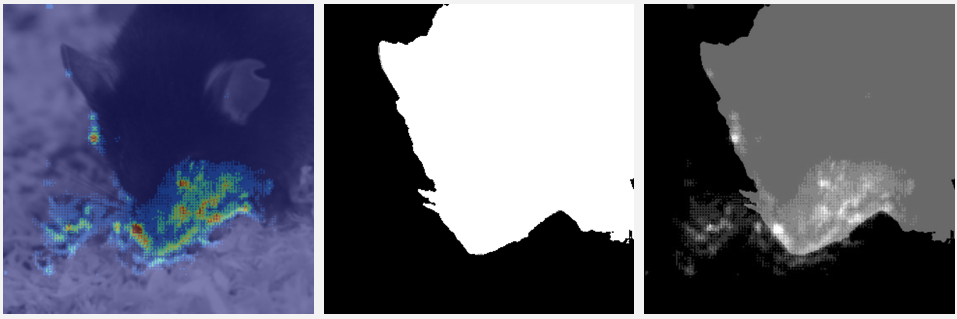

- Optional group-wise evaluation (e.g., per strain or subject), based on additional metadata

---
### Limitations
At the moment, the EvaluationPipeline supports only the resnet18 architecture, grayscale input images and cuda devices for the LRP analysis. If you plan to use a different model architecture, you will need to:
- Adapt the script explainability/LRP-for-ResNet/oneshot.py
- Create a matching config file in explainability/LRP-for-ResNet/configs/
- Modify the EvaluationPipeline to support RGB input, since images are currently converted to grayscale during loading

For grayscale images, segmentation masks must be binary:
- Foreground (region of interest) = white
- Background = black

Example masks:

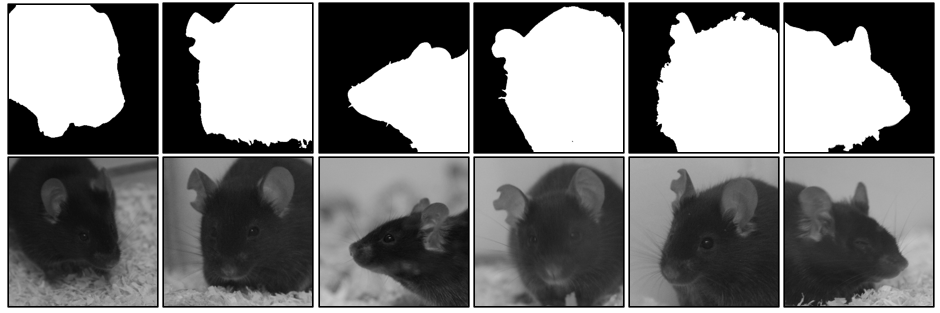

Moreover to use the per_strain evaluation a csv file must be provided with the following shape:
```python
strain_id, image_name
filename,strain_id
000210.jpg,0
000503.jpg,0
000506.jpg,0
000511.jpg,0
000531.jpg,0
000535.jpg,0
```

---

### Interpretation of the Results
The EvaluationPipeline produces a comprehensive view of model behavior across folds. It provides:
- Per-class accuracy on the validation set, including plots and aggregated metrics
- LRP visualizations for all validation images, highlighting regions that contributed to the prediction
- Relevance-in-ROI ratio, which quantifies how much of the model's attention (relevance) lies within the annotated foreground region.
This acts as a quantitative explainability score, helping assess whether the model is focusing on the correct image areas.
 

In [ ]:
log_dir = Path().resolve() / "results" / "gridsearch_demo"
k = 3
fold_seeds = [42, 43, 44]  # Seeds for each fold, should match the seeds used in the experiment
RUN_TO_EVAL_PATH = log_dir / "config_20250709_102533"
EVAL_BASE_DIR = log_dir / "eval"

PROJECT_ROOT = Path().resolve()                                       # Assuming the script is run from the project root directory
IMAGE_DIR = PROJECT_ROOT / "data" / "MGS_data"                        # Path to the directory containing images
STRAIN_CSV_PATH = PROJECT_ROOT /"data" / "dataset" / "strains.csv"    # Path to a CSV file with columns [filename, kind]; used for per-group evaluation (e.g., per strain)
MASK_PATH = PROJECT_ROOT /"data" / "dataset" / "nobg_manuell_mask"    # Path to the directory containing masks (if applicable)

for fold in range(k):
    MODEL_PATH = list((RUN_TO_EVAL_PATH / f"fold_{fold}").glob("*.pth"))[0]                             # For copying the model file to the evaluation directory
    CONFIG_PATH = RUN_TO_EVAL_PATH / "config.yaml"                                                      # For copying the config file to the evaluation directory
    TENSORBOARD_LOG_PATH = list((RUN_TO_EVAL_PATH / f"fold_{fold}").glob("events.out.tfevents.*"))[0]   # For copying the tensorboard log file to the evaluation directory
    OUTPUT_DIR = EVAL_BASE_DIR / f"fold_{fold}"
    LRP_MASK_PATH = OUTPUT_DIR / "sign_positive_attention_maps"

    pipeline = EvaluationPipeline(
        project_root=PROJECT_ROOT,                  # Path to the project root directory
        image_dir=IMAGE_DIR,                        # Path to the directory containing images  
        model_path=MODEL_PATH,                      # Path to the trained model file    
        config_path=CONFIG_PATH,                    # Path to the configuration file 
        tensorboard_log_path=TENSORBOARD_LOG_PATH,  # Path to the TensorBoard log file
        output_dir=OUTPUT_DIR,                      # Directory where evaluation results will be saved   
        strain_csv_path=STRAIN_CSV_PATH,            # Path to the CSV file with strain information (optional)
        masks_path=MASK_PATH,                       # Path to the directory containing masks (optional)
        lrp_masks_path=LRP_MASK_PATH,               # Directory where LRP masks will be saved (optional)   
        split_strategy="kfold",                     # Split strategy used for evaluation (e.g., "kfold" or "random")
        fold=fold,                                  # Current fold number (0-indexed) (ignored for RandomSplit)
        fold_num=k,                                 # Total number of folds in the KFold split (ignored for RandomSplit)
        seed=42,                                    # Splitting seed for reproducibility (should match the seed used in the experiment since the validation set for the fold is going to be loaded falsely)
        fold_seed=fold_seeds[fold]                  # Seed for the current fold (used for reproducibility)
    )

    # do_lrp only works with resnet18
    # do_lrp_roi_eval only works with resnet18 and requires the segmentation masks to be provided
    # per_strain is only possible if a strain csv file is provided 
    pipeline.evaluate_all(per_strain=True, do_class_eval=True, do_lrp=True, do_lrp_roi_eval=True)
    pipeline.evaluate_all(per_strain=False, do_class_eval=True, do_lrp=True, do_lrp_roi_eval=True)